In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import  StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
import tensorflow as tf

from keras.models import Sequential,load_model
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, GaussianNoise, Activation
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical 
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
#data function for reading and processing the train and test sets
#necessary as an input for the optimisation algorithm
def data():
    #define input processing function
    def process_attributes(df, train, test):
        
        #define and fit the scaler to the full dataset
        cs = MinMaxScaler()
        cs.fit(df_inputs.select_dtypes(np.number))
        
        #scale the numerical input variables
        trainContinuous = cs.transform(train.select_dtypes(np.number))
        testContinuous = cs.transform(test.select_dtypes(np.number))
        
        if 'Gender' in df.columns:
            
            #uncomment the code below to accommodate for any categorical columns
            zipBinarizer = LabelBinarizer().fit(df["Gender"])
            trainCategorical = zipBinarizer.transform(train["Gender"])
            testCategorical = zipBinarizer.transform(test["Gender"])

            # construct our training and testing data points by concatenating
            # the categorical features with the continuous features
            trainX = np.hstack([trainContinuous, trainCategorical])
            testX = np.hstack([testContinuous, testCategorical])
            
        else:
            trainX=trainContinuous
            testX=testContinuous
        
        # return the concatenated training and testing data
        return (trainX, testX)
    
    #read the excel datasets
    df = pd.read_excel('Cleaned_Dataframe_WithoutAge.xlsx')
    df.set_index('Sample',inplace=True)
    features=df.columns

    df_cancer = df.loc[df['Status'] == 'Cancer']
    df_control = df.loc[df['Status'] == 'Control']

    #randomly seelct 538 samples from the cancer population to create an equal sample size 
    df_cancer_small = df_cancer.sample(n=538, random_state = 100)

    df1 = pd.concat([df_cancer_small, df_control])
    #separate cancer markers and input data
    df_outputs= df1['Status']
    df_inputs = df1.drop(['Status'],axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(df_inputs, df_outputs, random_state=100, stratify=df_outputs, test_size=0.3)
    
    #process the input sets
    (X_train_sc, X_test_sc) = process_attributes(df_inputs, X_train, X_test)
    
    #encode the categorical output variables
    #encode categorical outputs
    lb = LabelBinarizer()
    lb.fit(y_train)
    train_outputs= lb.transform(y_train)
    test_outputs= lb.transform(y_test)

    Y_train = tf.keras.utils.to_categorical(train_outputs)
    Y_test = tf.keras.utils.to_categorical(test_outputs)

    return X_train_sc, Y_train, X_test_sc, Y_test, lb, features

In [3]:
#define model and search space for the optimisation algorithm
def model(X_train_sc, Y_train, X_test_sc, Y_test):
    
    #define ANN model and search space
    def ANN():
        
        #define first two layers, possible alternatives for neurons in each,
        #activation function, and dropout layers
        model=Sequential()
        Dropout_rate={{uniform(0, 0.3)}}
        model.add(Dense({{choice([8,16, 24, 32, 64])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))

        model.add(Dropout(Dropout_rate))

        model.add(Dense({{choice([8,16, 24, 32, 64])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))

        model.add(Dropout(Dropout_rate))
        
        #define output layer of the model
        
        model.add(Dense(2))
        model.add(Activation('softmax'))
        
        #define optimisation algorithm for network training
        optim=tf.keras.optimizers.Adam(learning_rate={{choice([ 0.001, 0.0005, 0.0001])}})
        
        #compile model and return it
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
        
        return model 
    
    #encode and transform labels for model training
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(np.argmax(Y_train,axis=1))
    
    #call the ANN and ddefine training epochs; define batch size alternatives
    net = KerasClassifier(build_fn = ANN,
                                 epochs={{choice([50,100,200])}},
                                 batch_size= {{choice([32,64])}},
                                 verbose = 0)
    model = ANN()
    
    #set up cross-validation scoring, and returned variables
    c = cross_val_score(net,
                    X_train_sc, y,
                    cv= StratifiedKFold(n_splits=5, shuffle=True),
                    scoring='accuracy').mean()
    print('Test accuracy:', c)
    return {'loss': -c, 'status': STATUS_OK, 'model': model}

In [4]:
#call in data function for test evaluation later
X_train, Y_train, X_test, Y_test, lb, features = data()
print('The model uses the following features:', features)

The model uses the following features: Index(['GP1', 'GP2', 'GP3', 'GP4', 'GP5', 'GP6', 'GP7', 'GP8', 'GP9', 'GP10',
       'GP11', 'GP12', 'GP13', 'GP14', 'GP15', 'GP16', 'GP17', 'GP18', 'GP19',
       'GP20', 'GP21', 'GP22', 'GP23', 'GP24', 'Gender', 'Status'],
      dtype='object')


In [5]:
#call the optimisation algorithm
best_run, best_model = optim.minimize(model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=Trials(),
                                      notebook_name='ANN_Optimisation_Balanced_WithoutAge')

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.pipeline import Pipeline
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
except:
    pass

try:
    from sklearn.compose import make_column_selector as selector
except:
    pass

try:
    from sklearn.compose import ColumnTransformer
except:
    pass

try:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras.models 

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                        
0.7091125827814568                                    
  2%|▏         | 1/50 [00:53<43:20, 53.06s/trial, best loss: -0.7091125827814568]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



Test accuracy:                                                                   
0.690543046357616                                                                
  4%|▍         | 2/50 [01:27<33:29, 41.86s/trial, best loss: -0.7091125827814568]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7037615894039736                                                               
  6%|▌         | 3/50 [02:02<30:23, 38.81s/trial, best loss: -0.7091125827814568]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7198233995584988                                                               
  8%|▊         | 4/50 [02:25<25:10, 32.83s/trial, best loss: -0.7198233995584988]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7224988962472405                                                               
 10%|█         | 5/50 [02:53<23:05, 30.80s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.6999116997792494                                                               
 12%|█▏        | 6/50 [03:24<22:40, 30.91s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.713103752759382                                                                
 14%|█▍        | 7/50 [03:41<18:57, 26.45s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.6387726269315672                                                               
 16%|█▌        | 8/50 [04:00<16:50, 24.06s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7052362030905076                                                               
 18%|█▊        | 9/50 [04:28<17:23, 25.45s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7025077262693158                                                               
 20%|██        | 10/50 [04:44<14:51, 22.30s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7078498896247241                                                                
 22%|██▏       | 11/50 [05:16<16:29, 25.37s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6958145695364238                                                                
 24%|██▍       | 12/50 [05:35<14:44, 23.27s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7064282560706402                                                                
 26%|██▌       | 13/50 [06:00<14:49, 24.03s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7105253863134658                                                                
 28%|██▊       | 14/50 [06:22<13:55, 23.20s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6971567328918321                                                                
 30%|███       | 15/50 [06:41<12:54, 22.12s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6945342163355408                                                                
 32%|███▏      | 16/50 [07:08<13:22, 23.61s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6986048565121413                                                                
 34%|███▍      | 17/50 [07:30<12:39, 23.01s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7025695364238411                                                                
 36%|███▌      | 18/50 [07:46<11:08, 20.90s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7091832229580574                                                                
 38%|███▊      | 19/50 [08:05<10:36, 20.52s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7105077262693158                                                                
 40%|████      | 20/50 [08:43<12:52, 25.74s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7211743929359824                                                                
 42%|████▏     | 21/50 [09:03<11:36, 24.02s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7077969094922738                                                                
 44%|████▍     | 22/50 [09:25<10:51, 23.26s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7170684326710817                                                                
 46%|████▌     | 23/50 [09:51<10:48, 24.00s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6998587196467991                                                                
 48%|████▊     | 24/50 [10:11<09:56, 22.95s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7210596026490066                                                                
 50%|█████     | 25/50 [10:31<09:11, 22.04s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7157350993377484                                                                
 52%|█████▏    | 26/50 [11:00<09:37, 24.05s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6972362030905076                                                                
 54%|█████▍    | 27/50 [11:26<09:28, 24.70s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7064724061810155                                                                
 56%|█████▌    | 28/50 [11:48<08:45, 23.89s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.705262693156733                                                                 
 58%|█████▊    | 29/50 [12:15<08:41, 24.81s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7064812362030904                                                                
 60%|██████    | 30/50 [12:42<08:27, 25.40s/trial, best loss: -0.7224988962472405]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7224988962472406                                                                
 62%|██████▏   | 31/50 [12:59<07:16, 23.00s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6905783664459161                                                                
 64%|██████▍   | 32/50 [13:26<07:13, 24.10s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6812715231788079                                                                
 66%|██████▌   | 33/50 [13:46<06:29, 22.89s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7145253863134657                                                                
 68%|██████▊   | 34/50 [14:11<06:18, 23.67s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7197792494481237                                                                
 70%|███████   | 35/50 [14:36<06:01, 24.09s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6998675496688741                                                                
 72%|███████▏  | 36/50 [14:56<05:18, 22.77s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6892626931567328                                                                
 74%|███████▍  | 37/50 [15:21<05:03, 23.37s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.699841059602649                                                                 
 76%|███████▌  | 38/50 [15:37<04:13, 21.15s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6785518763796909                                                                
 78%|███████▊  | 39/50 [15:56<03:44, 20.43s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6931390728476823                                                                
 80%|████████  | 40/50 [16:21<03:38, 21.87s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7104282560706403                                                                
 82%|████████▏ | 41/50 [16:57<03:55, 26.13s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7117969094922738                                                                
 84%|████████▍ | 42/50 [17:27<03:39, 27.45s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7025695364238411                                                                
 86%|████████▌ | 43/50 [18:17<03:59, 34.19s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.701271523178808                                                                 
 88%|████████▊ | 44/50 [18:43<03:09, 31.66s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7183487858719647                                                                
 90%|█████████ | 45/50 [19:03<02:20, 28.12s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7077086092715232                                                                
 92%|█████████▏| 46/50 [19:22<01:41, 25.27s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.703832229580574                                                                 
 94%|█████████▍| 47/50 [19:41<01:10, 23.62s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6985165562913906                                                                
 96%|█████████▌| 48/50 [20:16<00:53, 26.89s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6732715231788079                                                                
 98%|█████████▊| 49/50 [20:34<00:24, 24.37s/trial, best loss: -0.7224988962472406]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7171302428256071                                                                
100%|██████████| 50/50 [20:54<00:00, 25.10s/trial, best loss: -0.7224988962472406]


In [6]:
#display the parameters for the best performing model
print(best_run)

{'Activation': 0, 'Activation_1': 2, 'Dense': 3, 'Dense_1': 2, 'Dropout_rate': 0.18504626524775147, 'batch_size': 1, 'epochs': 1, 'learning_rate': 0}


In [7]:
best_model

In [8]:
#train the model to gt learning curves
batch=[32,64]
ep=[50,100,200]

history = best_model.fit(
    X_train, Y_train,
    batch_size=batch[best_run['batch_size']],
    epochs=ep[best_run['epochs']],
    verbose=1,
    validation_data=(X_test, Y_test),
    shuffle=False)

Epoch 1/100
12/12 [==============================] - 3s 80ms/step - loss: 0.7124 - accuracy: 0.4391 - val_loss: 0.7033 - val_accuracy: 0.3963
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6862 - accuracy: 0.5388 - val_loss: 0.6908 - val_accuracy: 0.5232
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6829 - accuracy: 0.5431 - val_loss: 0.6774 - val_accuracy: 0.5913
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6720 - accuracy: 0.5898 - val_loss: 0.6629 - val_accuracy: 0.6130
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6533 - accuracy: 0.6317 - val_loss: 0.6465 - val_accuracy: 0.6563
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 0.6400 - accuracy: 0.6438 - val_loss: 0.6295 - val_accuracy: 0.6780
Epoch 7/100
12/12 [==============================] - 0s 11ms/step - loss: 0.6149 - accuracy: 0.6776 - val_loss: 0.6148 - val_accuracy: 0.6749
Epoch 

12/12 [==============================] - 0s 6ms/step - loss: 0.5026 - accuracy: 0.7531 - val_loss: 0.5601 - val_accuracy: 0.7399
Epoch 59/100
12/12 [==============================] - 0s 6ms/step - loss: 0.4945 - accuracy: 0.7521 - val_loss: 0.5613 - val_accuracy: 0.7368
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.4984 - accuracy: 0.7435 - val_loss: 0.5583 - val_accuracy: 0.7337
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.4942 - accuracy: 0.7616 - val_loss: 0.5565 - val_accuracy: 0.7399
Epoch 62/100
12/12 [==============================] - 0s 5ms/step - loss: 0.5141 - accuracy: 0.7557 - val_loss: 0.5598 - val_accuracy: 0.7337
Epoch 63/100
12/12 [==============================] - 0s 7ms/step - loss: 0.4951 - accuracy: 0.7590 - val_loss: 0.5593 - val_accuracy: 0.7430
Epoch 64/100
12/12 [==============================] - 0s 8ms/step - loss: 0.5086 - accuracy: 0.7437 - val_loss: 0.5595 - val_accuracy: 0.7307
Epoch 65/100
12/12 

In [9]:
#save resulting model in callable file
best_model.summary()
best_model.save('ANN Models/all_inputs_balanced_WithoutAge_model.h5')
print("Saved model to directory")

Model: "sequential_180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_540 (Dense)            (None, 32)                832       
_________________________________________________________________
activation_540 (Activation)  (None, 32)                0         
_________________________________________________________________
dropout_360 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_541 (Dense)            (None, 24)                792       
_________________________________________________________________
activation_541 (Activation)  (None, 24)                0         
_________________________________________________________________
dropout_361 (Dropout)        (None, 24)                0         
_________________________________________________________________
dense_542 (Dense)            (None, 2)              

In [10]:
#Calculate the labels for the test set
predictions = best_model.predict(X_test)

In [11]:
#evaluate test performance of the model
print('Cancer is encoded by',lb.transform(['Cancer']), ', while Control is encoded by',lb.transform(['Control']))
print(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1)))
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1), target_names=lb.classes_))

Cancer is encoded by [[0]] , while Control is encoded by [[1]]
[[107  55]
 [ 33 128]]
              precision    recall  f1-score   support

      Cancer       0.76      0.66      0.71       162
     Control       0.70      0.80      0.74       161

    accuracy                           0.73       323
   macro avg       0.73      0.73      0.73       323
weighted avg       0.73      0.73      0.73       323



In [12]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


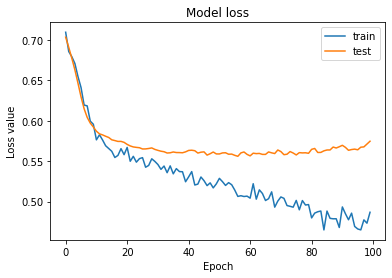

In [13]:
from matplotlib import pyplot as plt
# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

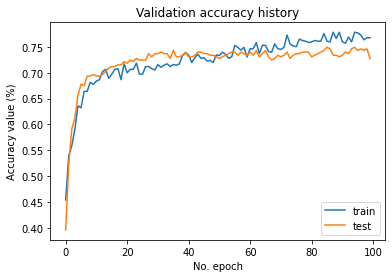

In [14]:
# Plot history: Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()